In [46]:
from db import databaseconnection
import numpy as np
from ga import networkedgeneticalgorithm as nga
from membranesimulation import MembraneSimulation
import parlammps
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import networkx
from tools import vectools
import os
import tools
import copy
import random
import pprint
import time
import pandas as pd
import holoviews as hv
import seaborn as sns



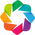

In [47]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
pp = pprint.PrettyPrinter(indent=4)
hv.extension('bokeh')
%output widgets='live' holomap='scrubber'

In [48]:
dbconn = databaseconnection.DatabaseConnection('/Users/joel/Projects/emergent-optimiser/db/datastore.db')
session = dbconn.getLastSession()
individuals = session.getIndividualsList()

In [49]:
def greatArcDist(Ang1, Ang2, rad=4):
    #Ang = (PolarAng,AziAng)
    #https://math.stackexchange.com/questions/231221/great-arc-distance-between-two-points-on-a-unit-sphere
    arcDist=rad*(np.arccos((np.cos(Ang1[0])*np.cos(Ang2[0]))+((np.sin(Ang1[0])*np.sin(Ang2[0]))*(np.cos(Ang1[1]-Ang2[1])))))
    return arcDist

In [50]:
#fitness given genome
def genomeFitness(genome):
    for individual in individuals:
        if np.array_equal(individual.genomePickle, genome):
            return individual.fitness
    return -1

In [51]:
def getFitness(ind):
    return genomeFitness(ind.genomePickle) if ind != None and ind.genomePickle.any() != None else -1

In [52]:
def buildLigandNetwork(ligands, silent=True):
    if not silent:
        startTime = time.time()
    G=networkx.Graph()
    
    nIndex = 1
    for i in ligands:
        if i.eps > 0.0:
            G.add_node(nIndex,weight=i.eps,polAng=i.polAng,aziAng=i.aziAng)
        nIndex += 1
    
    iIndex = 1
    for i in ligands:
        jIndex = 1
        for j in ligands:
            if i < j:
                cartDist = 1.0/greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng))
                #affDist = abs(i.eps - j.eps)
                if i.eps > 0.0 and j.eps > 0.0:
                    G.add_edge(iIndex, jIndex, weight=cartDist)
            jIndex += 1
        iIndex += 1
    return G

In [53]:
def buildPrunedLigandNetwork(ind,pruning):
    G = buildLigandNetwork(ind.phenomePickle.particle.ligands)

    prunes = []
    for e in G.edges:
        w = G.get_edge_data(*e)['weight']
        if(w<pruning):
            prunes.append(e)

    G.remove_edges_from(prunes)
    return G
    

In [54]:
def buildNetworkView(ind,pruning):
    G = buildPrunedLigandNetwork(ind,pruning)
    padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))
    return hv.Graph.from_networkx(G, networkx.layout.spring_layout).opts(plot=dict(color_index='weight')).redim.range(**padding)

In [55]:
def hammingDistance(s1,s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

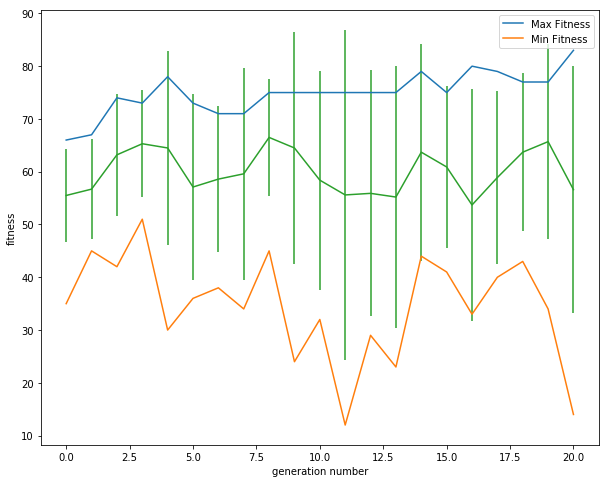

In [56]:
metrics = session.metrics.metricsPickle

gens = [i for i in range(len(metrics))]
avg = [m['avg'] for m in metrics]
std = [m['std'] for m in metrics]

plt.figure()

plt.plot([m['max'] for m in metrics],label='Max Fitness');
plt.plot([m['min'] for m in metrics],label='Min Fitness');
plt.errorbar(gens, avg, std)
plt.xlabel('generation number')
plt.ylabel('fitness')
plt.legend();

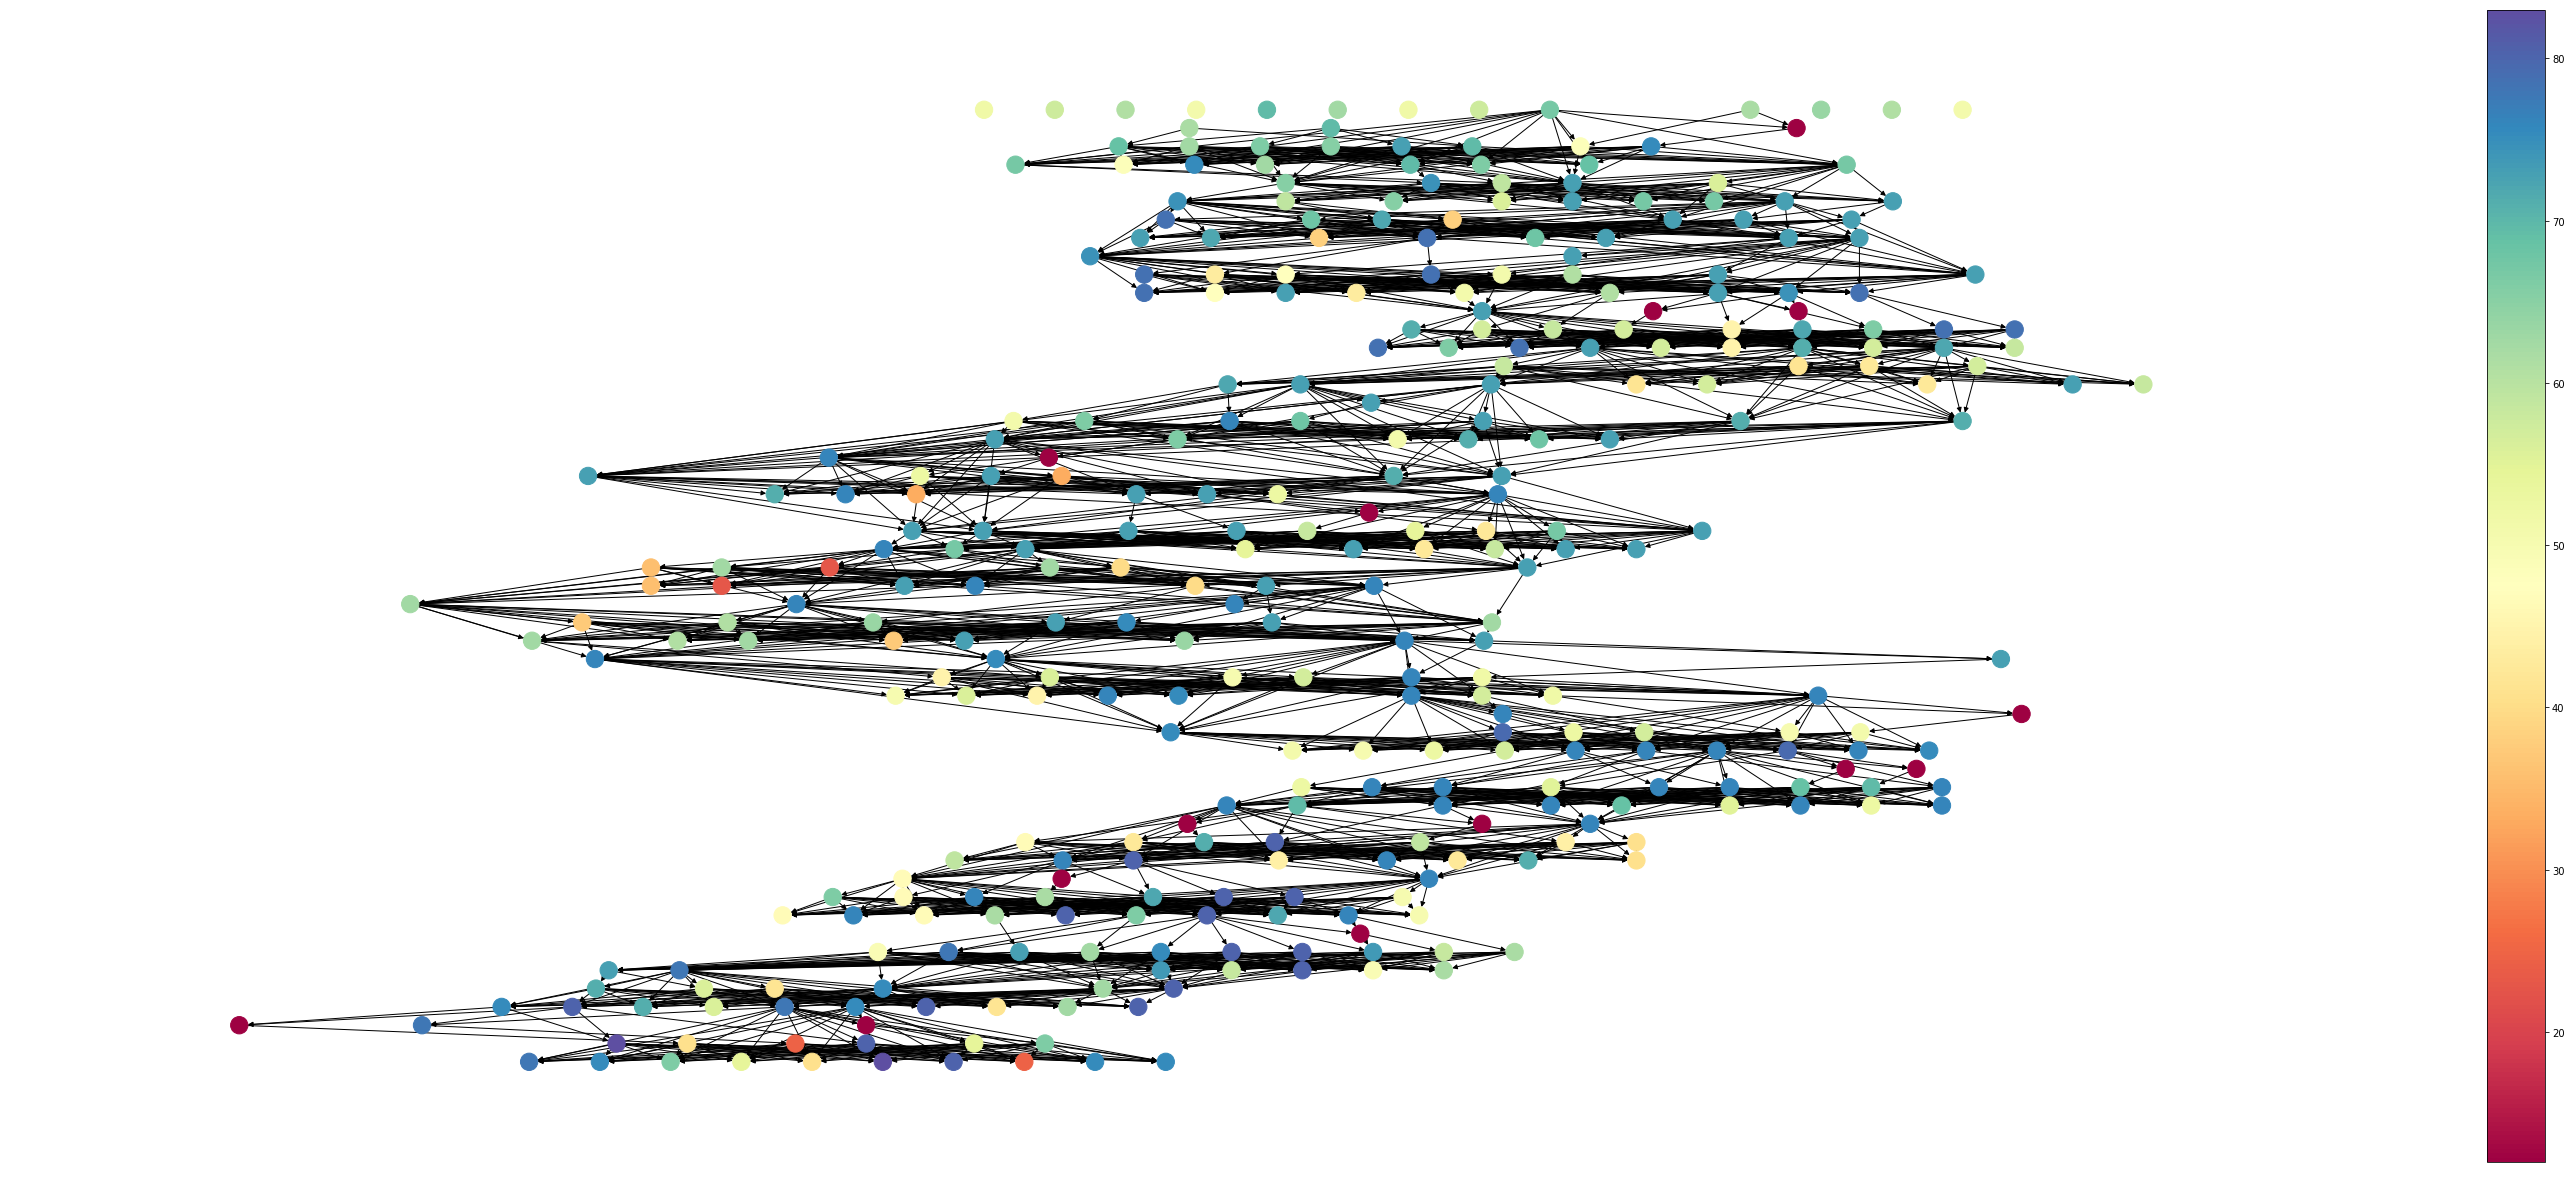

In [57]:
plt.rcParams['figure.figsize'] = (40.0, 16.0)
genealogy = session.genealogy
tree = networkx.DiGraph(genealogy.treePickle)
tree = tree.reverse()
colors = [genomeFitness(genealogy.historyPickle[i]) for i in tree]
positions = networkx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")
networkx.draw(tree, positions, node_color = colors, s=40, cmap=plt.cm.Spectral)
fits = [ individual.fitness for individual in individuals]
sm = plt.cm.ScalarMappable(cmap=plt.cm.Spectral, norm=plt.Normalize(vmin=float(min(fits)), vmax=float(max(fits))))
sm._A = []
plt.colorbar(sm)
plt.show()

In [58]:
buildNetworkView(individuals[-1],0.3)

:Graph   [start,end]

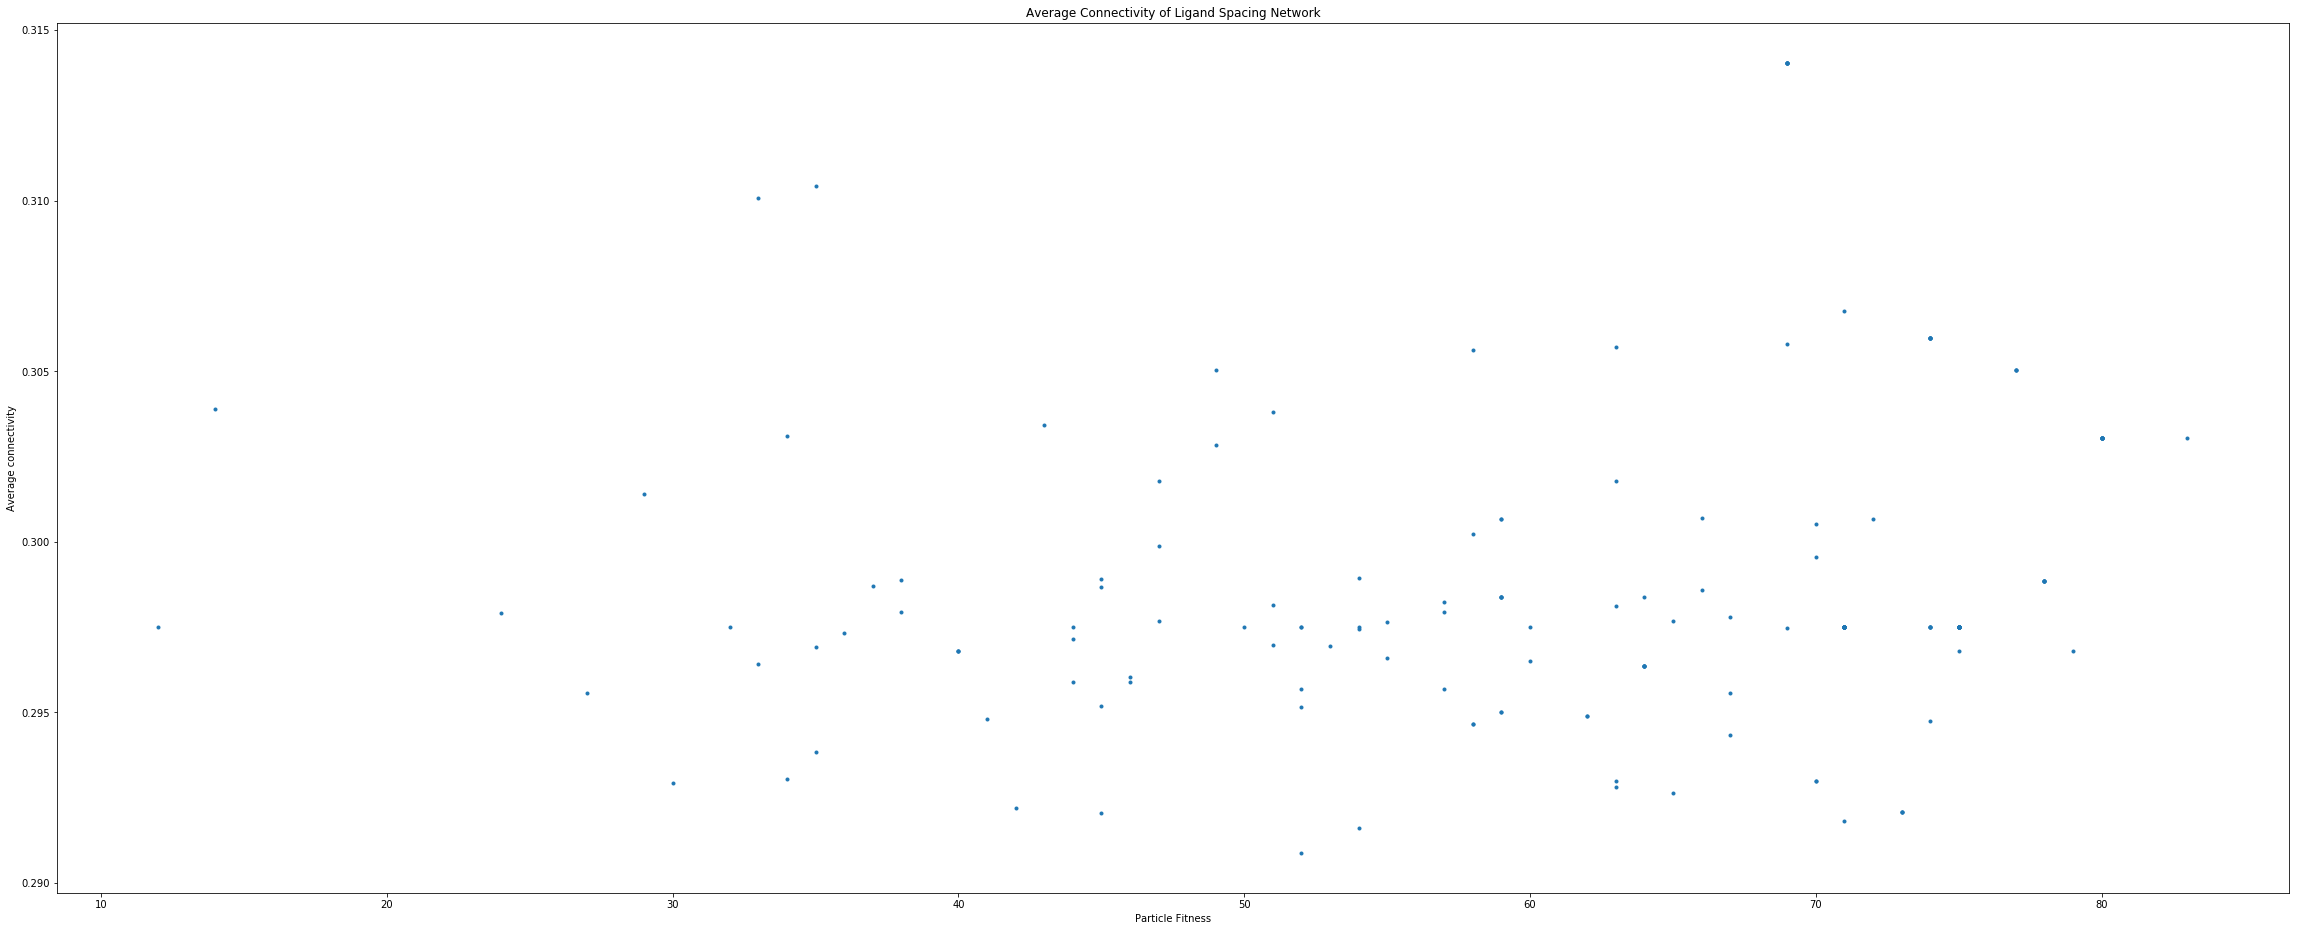

In [60]:
cFitness = []

for i in individuals:
    G = buildPrunedLigandNetwork(i,0)

    #clustering = networkx.clustering(G,weight='weight')
    c = networkx.average_clustering(G,weight='weight')
    cFitness.append((getFitness(i),c))

    
#     knn = networkx.k_nearest_neighbors(G, weight='weight')
#     knearest.append((i['fitness'],knn))
    
plt.plot([k[0] for k in cFitness],[k[1] for k in cFitness],'.')

axes = plt.gca()
# axes.set_xlim([700,800])
# axes.set_ylim([ymin,ymax])

plt.xlabel('Particle Fitness')
plt.ylabel('Average connectivity')
plt.title('Average Connectivity of Ligand Spacing Network')
plt.show()

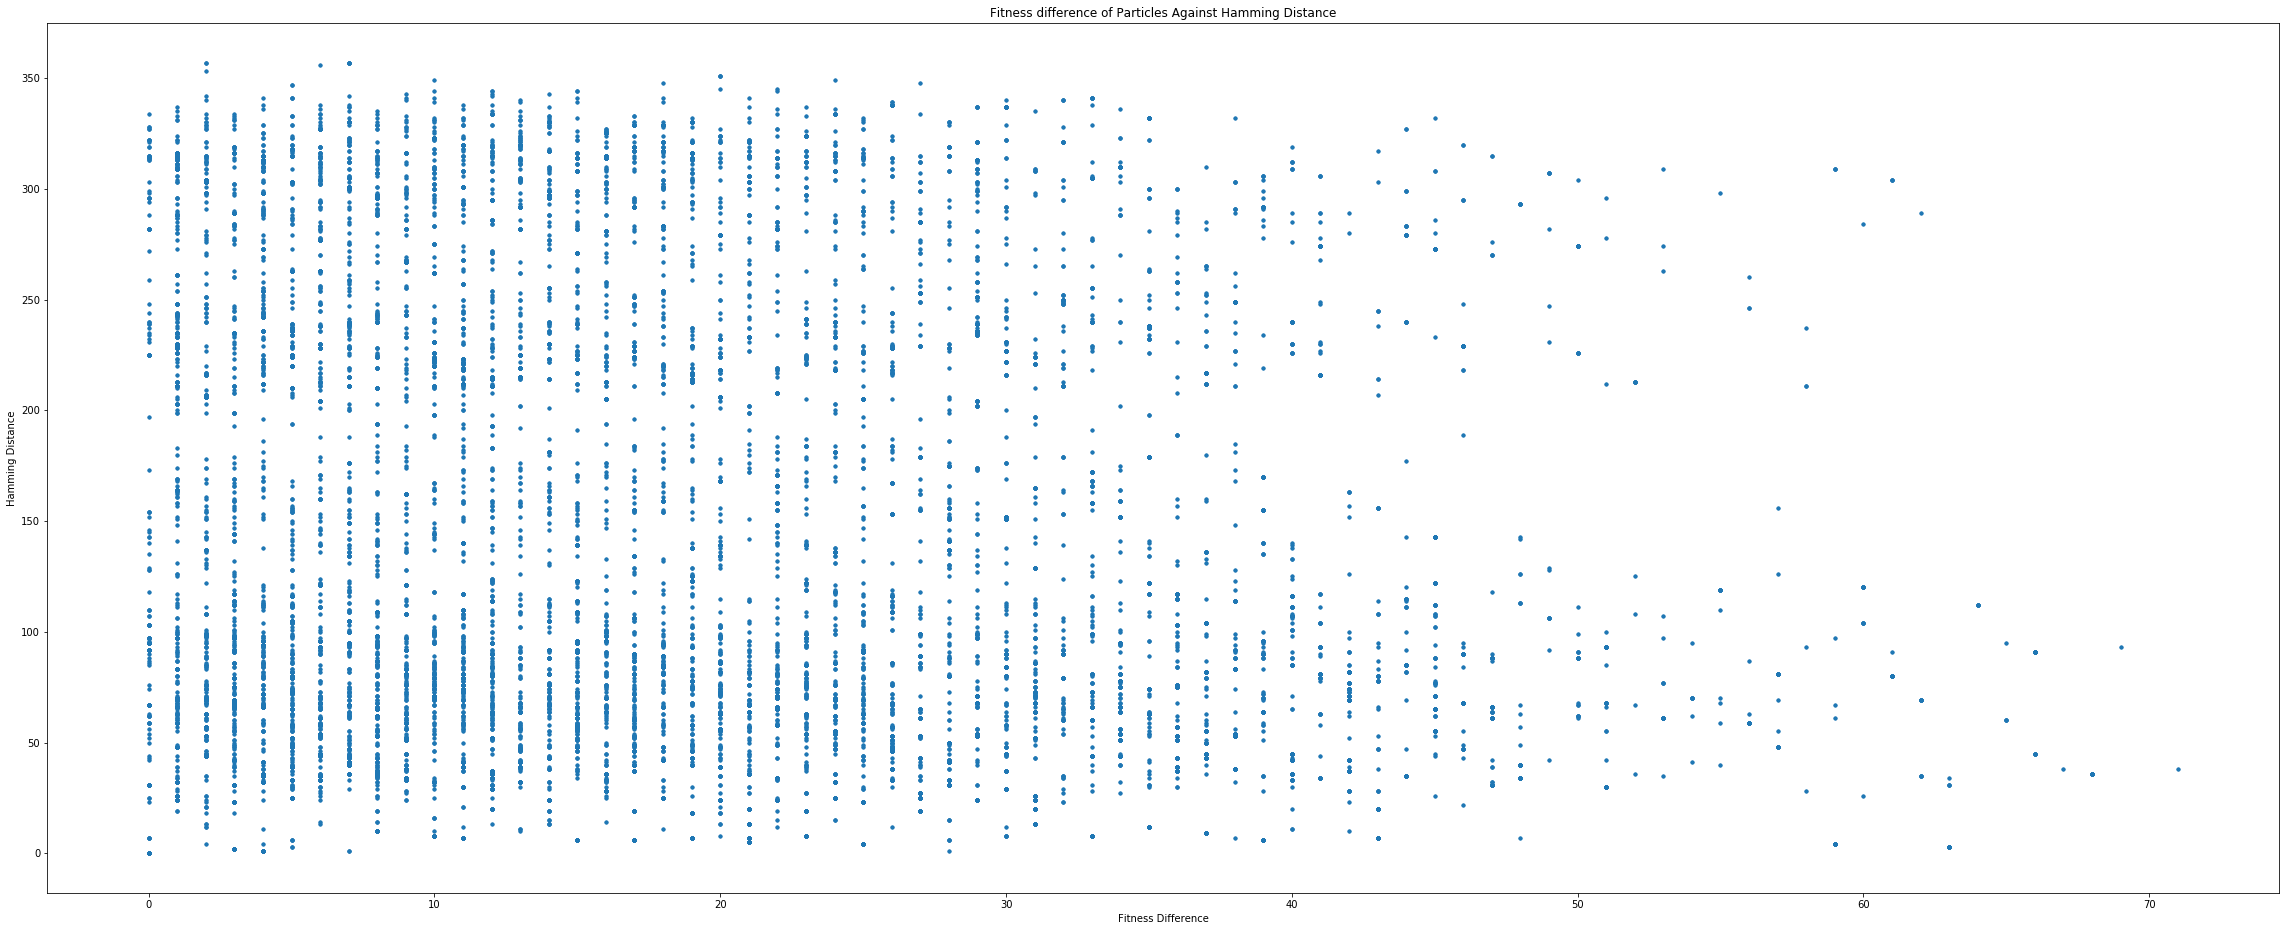

In [61]:
fitDiff = []
hamming = []

for i in individuals:
    for j in individuals:
        if i!=j:
            fitDiff.append(abs(getFitness(i)-getFitness(j)))
            hamming.append(hammingDistance(i.genome,j.genome))
            
plt.figure()
plt.plot(fitDiff,hamming,'.')
plt.xlabel('Fitness Difference')
plt.ylabel('Hamming Distance')
plt.title('Fitness difference of Particles Against Hamming Distance')
plt.show()

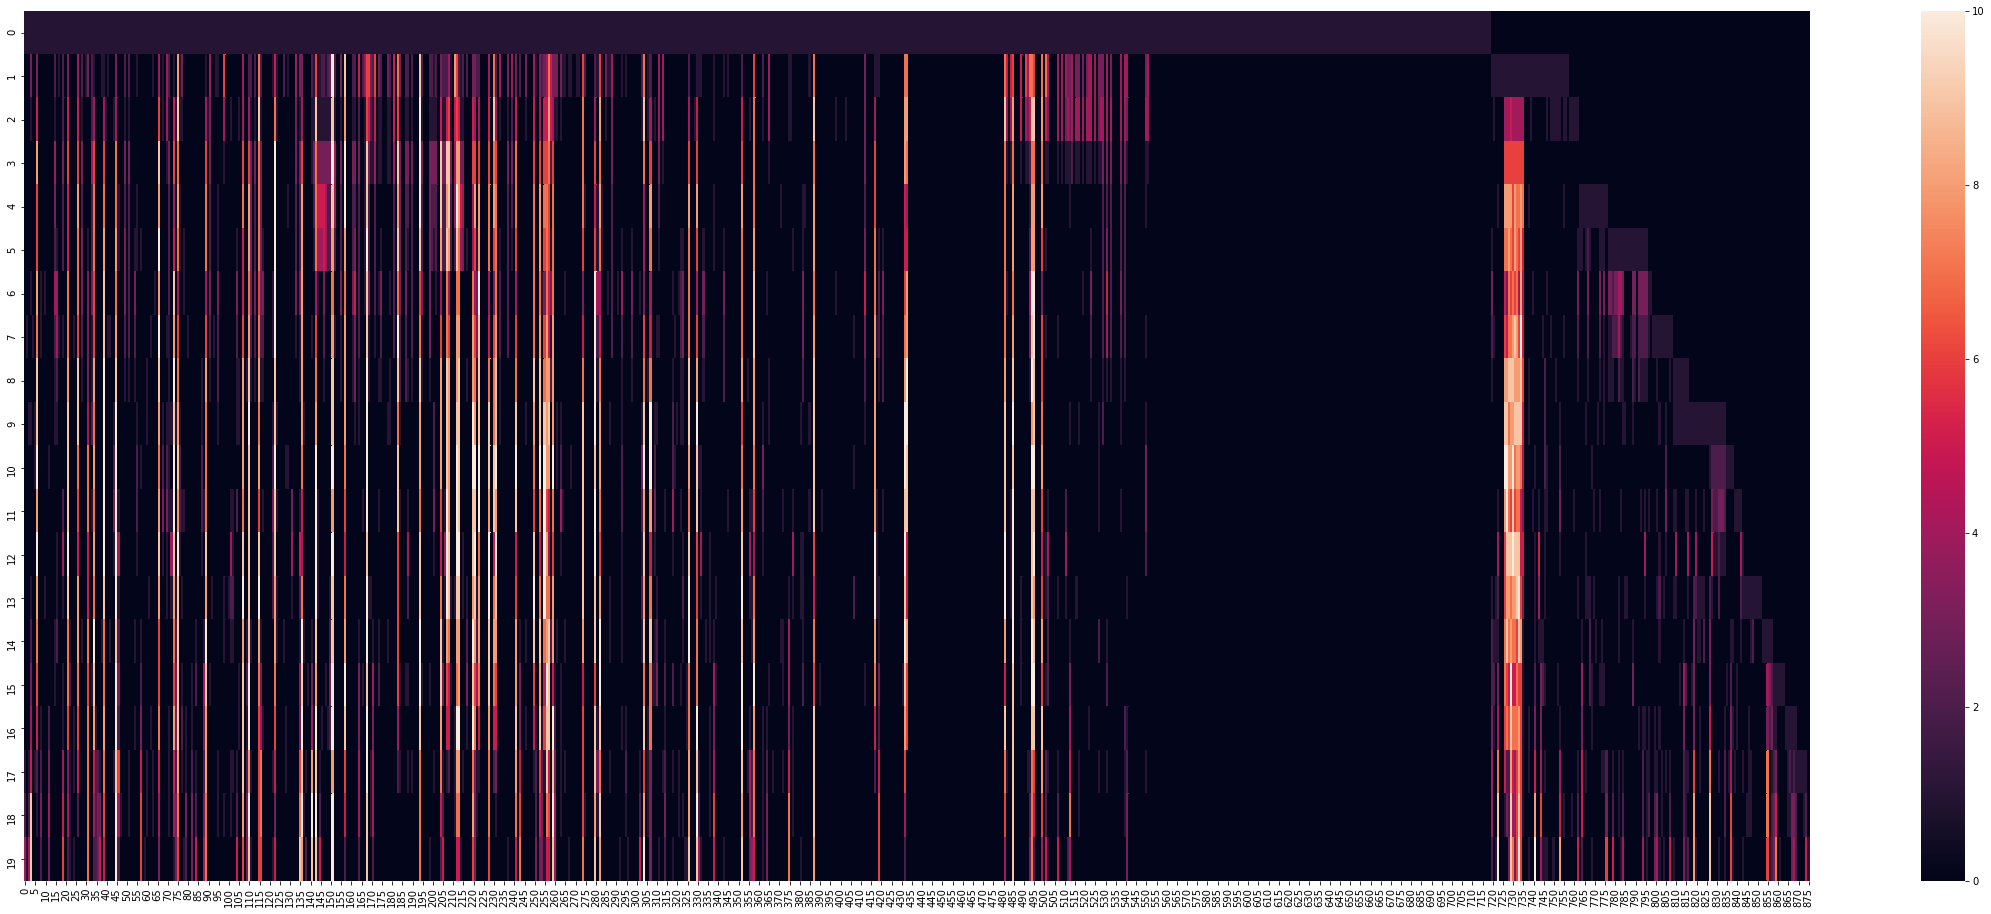

In [62]:
generations = session.generations
genes = session.getGenesList()

xticks = [str(g.pID) for g in genes]

data = []

i = 0

for gen in generations:
    data.append([])
    j = 0
    for g in genes:
        data[i].append(0)
        for ind in g.individuals:
            if ind.gen == gen:
                data[i][j]+=1
        j+=1
    i += 1

ax = sns.heatmap(data)